In [2]:
import pandas as pd
import numpy as np
import csv
import itertools

import torch
import torch.nn as nn  # neural network modules
import torch.nn.functional as F  # activation functions
import torch.optim as optim  # optimizer
from torch.autograd import Variable # add gradients to tensors
from torch.nn import Parameter # model parameter functionality 

In [3]:
# Read in data
df_orig = pd.read_csv("FakeNewsDetection/train.csv")
df = df_orig.iloc[:10200].reset_index(drop=True)

# Fix target label
label_encodings = {
    'pants-fire': 0, 
    'false':      1, 
    'barely-true':2, 
    'half-true':  3, 
    'mostly-true':4,
    'true':       5
}
df['target'] = df['label'].apply(lambda x: label_encodings[x])

### Glove Model

In [4]:
# Read Glove file
words = pd.read_table("glove.6B.100d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

# Generate Glove dictionary
glove = {word:words.iloc[idx].values for (word,idx) in zip(words.index,range(words.shape[0]))}

In [5]:
# Split the text into words
df['words'] = df['statement'].apply(lambda x: x.replace('?',' ?').replace('.',' .').\
                                    lower().split())

# Generate the list of all vocab words in our data
target_vocab = list(itertools.chain.from_iterable(df['words']))
target_vocab = list(set(target_vocab))

In [6]:
# Generate the weights_matrix, which is the matrix of word embeddings that we
# pass into Pytorch. It contains len(target_vocab) rows for each of the words,
# each represented by a length-100 vector – taken from the Glove embedding
weights_matrix = np.zeros((len(target_vocab)+1,100))

# Add in vocab
error_count = 0
word_to_idx = {}
for i, word in enumerate(target_vocab):
    word_to_idx[word] = i
    try: 
        weights_matrix[i] = glove[word]
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=100)
        error_count += 1

# Add in "empty" token
word_to_idx[""] = len(target_vocab)
        
print(f"We found {error_count} out of {len(target_vocab)} words not in the Glove model")

We found 5373 out of 16980 words not in the Glove model


In [7]:
# Pad the text to have length 100
df['words'] = df['words'].apply(lambda x: x[:100]+([""]*(100-len(x[:100]))))

# Encode text using the indices
df['text_idx'] = df['words'].apply(lambda lst: np.array([word_to_idx[w] for w in lst]))

In [8]:
def create_emb_layer(weights_matrix, 
                     non_trainable=False):
    weights_matrix = torch.Tensor(weights_matrix)
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

### FakeBERT

In [9]:
def get_accuracy(output, targets):

    predicted = [int(y_pred.detach().argmax(-1)) for y_pred in output]
    targets = [int(y) for y in targets]
    correct = sum(a==b for (a,b) in zip(predicted, targets))
    accuracy = 100*correct/len(targets) 

    return accuracy

def train(data,
          test,
          weights_matrix,
          num_epochs = 10,
          batch_size = 100,
          learning_rate = 0.1):
    
    # Instantiate model & optimization 
    model = FakeBERT(weights_matrix)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Iterate over epochs
    for ep in range(num_epochs):
        
        model.train()

        # Iterate over batches
        for i in range(data.shape[0]//batch_size):

            # Declare features and target labels
            X = torch.Tensor([train_data for train_data in data['text_idx'][i*batch_size:(i+1)*batch_size]]).to(dtype=torch.long)
            y = data['target'][i*batch_size:(i+1)*batch_size].values
            y = torch.Tensor(y).to(dtype=torch.long)

            # Get predictions from model
            pred = model(X)

            # Calculate loss
            loss_func = nn.CrossEntropyLoss()
            loss = loss_func(pred, y)

            # Backpropagate
            loss.backward()

            # Update parameters
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()

        # Evaluate model
        model.eval()

        # Prepare test data
        test_X = torch.Tensor([test_data for test_data in test['text_idx']]).to(dtype=torch.long)
        test_y = test['target'].values
        test_y = torch.Tensor(test_y).to(dtype=torch.long)
            
        # Evaluate on test data
        test_pred = model(test_X)
        test_accuracy = get_accuracy(test_pred, test_y)
        
        # Print accuracy
        print(f"Test accuracy: {test_accuracy} at epoch: {ep}")

    return model

In [10]:
class FakeBERT(nn.Module):
    def __init__(self, weights_matrix):
        super(FakeBERT, self).__init__()
        
        # Layer 0: Embedding Layer
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

        # Layer 1: Conv1D + Maxpool
        self.conv_1 = nn.Conv1d(in_channels=100, out_channels=128, kernel_size=3, stride=1)
        self.sigm_1 = nn.Sigmoid()
        self.pool_1 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 2: Conv1D + Maxpool
        self.conv_2 = nn.Conv1d(in_channels=100, out_channels=128, kernel_size=4, stride=1)
        self.sigm_2 = nn.Sigmoid()
        self.pool_2 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 3: Conv1D + Maxpool
        self.conv_3 = nn.Conv1d(in_channels=100, out_channels=128, kernel_size=5, stride=1)
        self.sigm_3 = nn.Sigmoid()
        self.pool_3 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 4: Conv1D + Maxpool
        self.conv_4 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, stride=1)
        self.sigm_4 = nn.Sigmoid()
        self.pool_4 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 5: Conv1D + Maxpool
        self.conv_5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, stride=1)
        self.sigm_5 = nn.Sigmoid()
        self.pool_5 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 6: Fully Connected Layer 
        self.full_6 = nn.Linear(128,32)
        self.sigm_6 = nn.Sigmoid()
        
        # Layer 7: Fully Connected Layer 
        self.full_7 = nn.Linear(32,6)
        self.soft_7 = nn.Softmax()
        
    def forward(self, x):
        # Generate the embeddings with Glove
        emb = self.embedding(x)

        # Generate the 3 1D conv layers
        conv_1 = self.pool_1(self.sigm_1(self.conv_1(emb)))
        conv_2 = self.pool_2(self.sigm_2(self.conv_2(emb)))        
        conv_3 = self.pool_3(self.sigm_3(self.conv_3(emb)))
        
        # Concatenate the 3 layers
        cat = torch.cat((conv_1,conv_2,conv_3),2)
        
        # Pass the concatenated output through 2 1D conv layers
        conv_4 = self.pool_4(self.sigm_4(self.conv_4(cat)))        
        conv_5 = self.pool_5(self.sigm_5(self.conv_5(conv_4)))  

        # Flatten the output
        flat = conv_5.flatten(start_dim=1)

        # Pass through 2 fully connected layers
        full_6 = self.sigm_6(self.full_6(flat))
        full_7 = self.soft_7(self.full_7(full_6))
        
        return full_7

In [11]:
data = df.iloc[:10000].reset_index(drop=True)
test = df.iloc[10000:].reset_index(drop=True)

In [12]:
model = train(data, 
              test, 
              weights_matrix)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Test accuracy: 18.5 at epoch: 0
Test accuracy: 21.0 at epoch: 1
Test accuracy: 21.0 at epoch: 2
Test accuracy: 21.0 at epoch: 3
Test accuracy: 21.0 at epoch: 4
Test accuracy: 21.0 at epoch: 5
Test accuracy: 21.0 at epoch: 6
Test accuracy: 21.0 at epoch: 7
Test accuracy: 21.0 at epoch: 8
Test accuracy: 21.0 at epoch: 9


## Testing on Generated Input

In [13]:
# Read in data
df_pos = pd.read_csv("liar_positive.csv")
df_neg = pd.read_csv("liar_negative.csv")

In [14]:
# Generate embeddings from Glove for positive statement dataset
df_pos['target'] = df_pos['label'].apply(lambda x: label_encodings[x])
df_pos['words'] = df_pos['statement'].apply(lambda x: x.\
                                            replace('?',' ?').\
                                            replace('.',' .').\
                                            lower().split())
df_pos['words'] = df_pos['words'].apply(lambda x: x[:100]+([""]*(100-len(x[:100]))))
df_pos['text_idx'] = df_pos['words'].apply(lambda lst: np.array([word_to_idx[w] for w in lst]))

# Generate embeddings from Glove for negative statement dataset
df_neg['target'] = df_neg['label'].apply(lambda x: label_encodings[x])
df_neg['words'] = df_neg['statement'].apply(lambda x: x.\
                                            replace('?',' ?').\
                                            replace('.',' .').\
                                            lower().split())
df_neg['words'] = df_neg['words'].apply(lambda x: x[:100]+([""]*(100-len(x[:100]))))
df_neg['text_idx'] = df_neg['words'].apply(lambda lst: np.array([word_to_idx[w] for w in lst]))

In [16]:
# Fix input and target for model prediction and evaluation
input_pos = torch.Tensor([train_data for train_data in df_pos['text_idx']]).to(dtype=torch.long)
target_pos = torch.Tensor(df_pos['target'].values).to(dtype=torch.long)

input_neg = torch.Tensor([train_data for train_data in df_neg['text_idx']]).to(dtype=torch.long)
target_neg = torch.Tensor(df_neg['target'].values).to(dtype=torch.long)

In [18]:
# Predictions
pred_pos = model(input_pos)
pred_neg = model(input_neg)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(array([  1.,   7.,  27.,  57.,  76., 134., 176., 164., 208., 218., 191.,
        206., 233., 217., 194., 154., 175., 145., 138., 127., 123.,  97.,
         95.,  87.,  71.,  60.,  61.,  40.,  39.,  26.,  26.,  27.,  26.,
         15.,  24.,  17.,  12.,   9.,   9.,   7.,   5.,   3.,   5.,   4.,
          1.,   1.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   1.]),
 array([0.00000000e+00, 6.91145942e-07, 1.38229188e-06, 2.07343783e-06,
        2.76458377e-06, 3.45572971e-06, 4.14687565e-06, 4.83802160e-06,
        5.52916754e-06, 6.22031348e-06, 6.91145942e-06, 7.60260536e-06,
        8.29375131e-06, 8.98489725e-06, 9.67604319e-06, 1.03671891e-05,
        1.10583351e-05, 1.17494810e-05, 1.24406270e-05, 1.31317729e-05,
        1.38229188e-05, 1.45140648e-05, 1.52052107e-05, 1.58963567e-05,
        1.65875026e-05, 1.72786486e-05, 1.79697945e-05, 1.86609404e-05,
        1.93520864e-05, 2.00432323e-05, 2.07343783e-05, 2.14255242e-05,
        2.2116

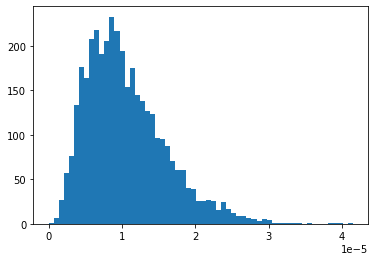

In [40]:
# Difference between predictions
import matplotlib.pyplot as plt
plt.hist([torch.norm(pos-neg,2).item() for (pos,neg) in zip(pred_pos, pred_neg)], bins=60)

In [36]:
np.mean([p==n for (p,n) in zip([pred.argmax().item() for pred in pred_pos],
[pred.argmax().item() for pred in pred_neg])])

1.0